# ACOM Tutorial Notebook - Basics

In this tutorial, you will learn the basic concepts and syntax of the ACOM module in py4DSTEM.

### Acknowledgements

This tutorial notebook was written by Colin Ophus and Steven Zeltmann. Contact clophus@lbl.gov with any questions.

### Versioning

Last updated on 2022-01-13 with py4DSTEM v.0.12.6.

In [359]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [360]:
import py4DSTEM
import numpy as np

In [367]:
# Define manual triclinic structure using manual input
pos = np.array([
    [0.0, 0.0, 0.0],
])
atom_num = 42
cell = [3,4,5, 70,90,110]

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

In [368]:
# # Importing pymatgen - you need to install pymatgen if you want to use pymatgen structures or their cif importer.
# from pymatgen.core.structure import Structure, Lattice

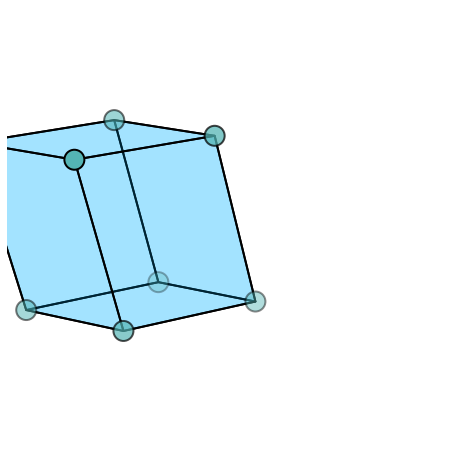

In [370]:
# Plot the structure
fig, ax = crystal.plot_structure(
    returnfig=True,
)

In [371]:
# Save the structure plot
# fig.savefig('plot_00_atomic_struct.pdf')

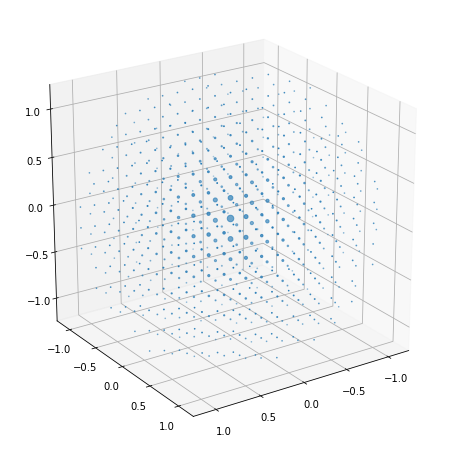

In [372]:
k_max = 1.5
crystal.calculate_structure_factors(k_max)

fig, ax = crystal.plot_structure_factors(
    proj_dir=[3,2,1],
    plot_limit=1.2,
    returnfig=True)

In [10]:
# Save the structure factor plot
# fig.savefig('plot_01_structure_factors.pdf')

### Generate and plot some diffraction patterns

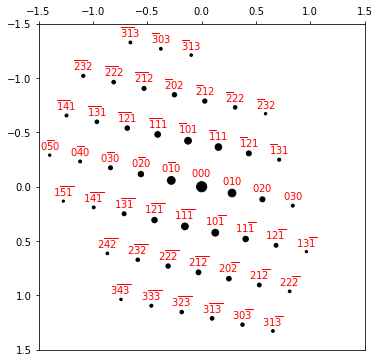

In [373]:
# zone_axis_test = [1,1,1]  # Zone axis
# zone_axis_test = [0,1,1]  # Zone axis
# zone_axis_test = [0,0,1]  # Zone axis
zone_axis_test = [1,2,3]  # Zone axis
# x_proj_dir_test = [0,1,1] # x direction in-plane vector (optional)

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis = zone_axis_test,
#     proj_x_axis = x_proj_dir_test,
    sigma_excitation_error=0.02)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks,
    plot_range_kx_ky=[k_max,k_max],
)

### Testing orientation matching

In [375]:
# # Create an orientation plan
# crystal.orientation_plan(
#     angle_step_zone_axis = 2.0,
#     angle_step_in_plane = 2.0,
#     accel_voltage = 300e3,
#     corr_kernel_size=0.08,
# )

# Create an orientation plan with an automatic range of zone axes - this requires pymatgen to be installed!
crystal.orientation_plan(
    angle_step_zone_axis = 5.0,
    angle_step_in_plane = 5.0,
    accel_voltage = 300e3,
    corr_kernel_size=0.08,
    zone_axis_range='auto',
)

Automatically detected point group -1, using arguments: zone_axis_range=full, fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|███████████████████████████████████████████████████████| 685/685 [00:11<00:00, 61.68 zone axes/s]


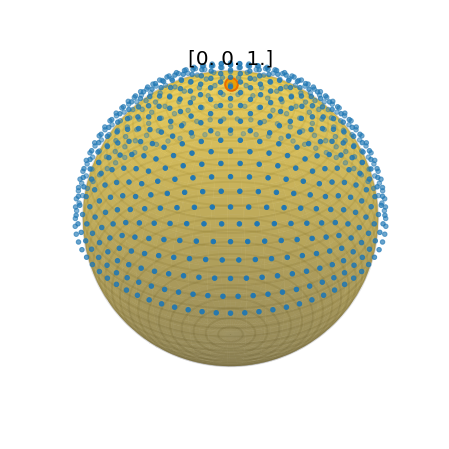

In [376]:
# Plot the zone axes included in the orientation plan
fig, ax = crystal.plot_orientation_zones(
    plot_limit=np.array([-0.8, 0.8]),
    returnfig=True)

In [377]:
# Save the zone axes orientation map
# fig.savefig('plot_02_zone_axes.pdf')

Orientation plan index 38


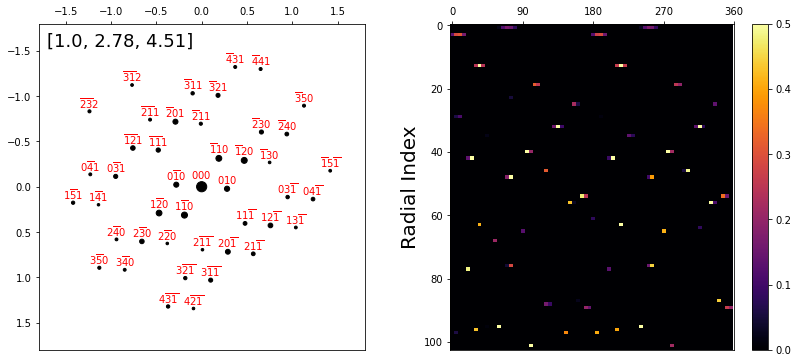

In [378]:
# Plot some of the orientation plans
fig, ax = crystal.plot_orientation_plan(
#     zone_axis_plot=[1,1,3],
#     zone_axis_plot=[1,2,3],
    zone_axis_plot=[1,3,5],
    returnfig=True,
);

In [379]:
# Save the zone axes orientation map
# fig.savefig('plot_03_plan_05.pdf')

Input zone axis    = ([-0.267 -0.535 -0.802])
Best fit zone axis = ([-0.279 -0.525 -0.804]) with corr value = 0.557


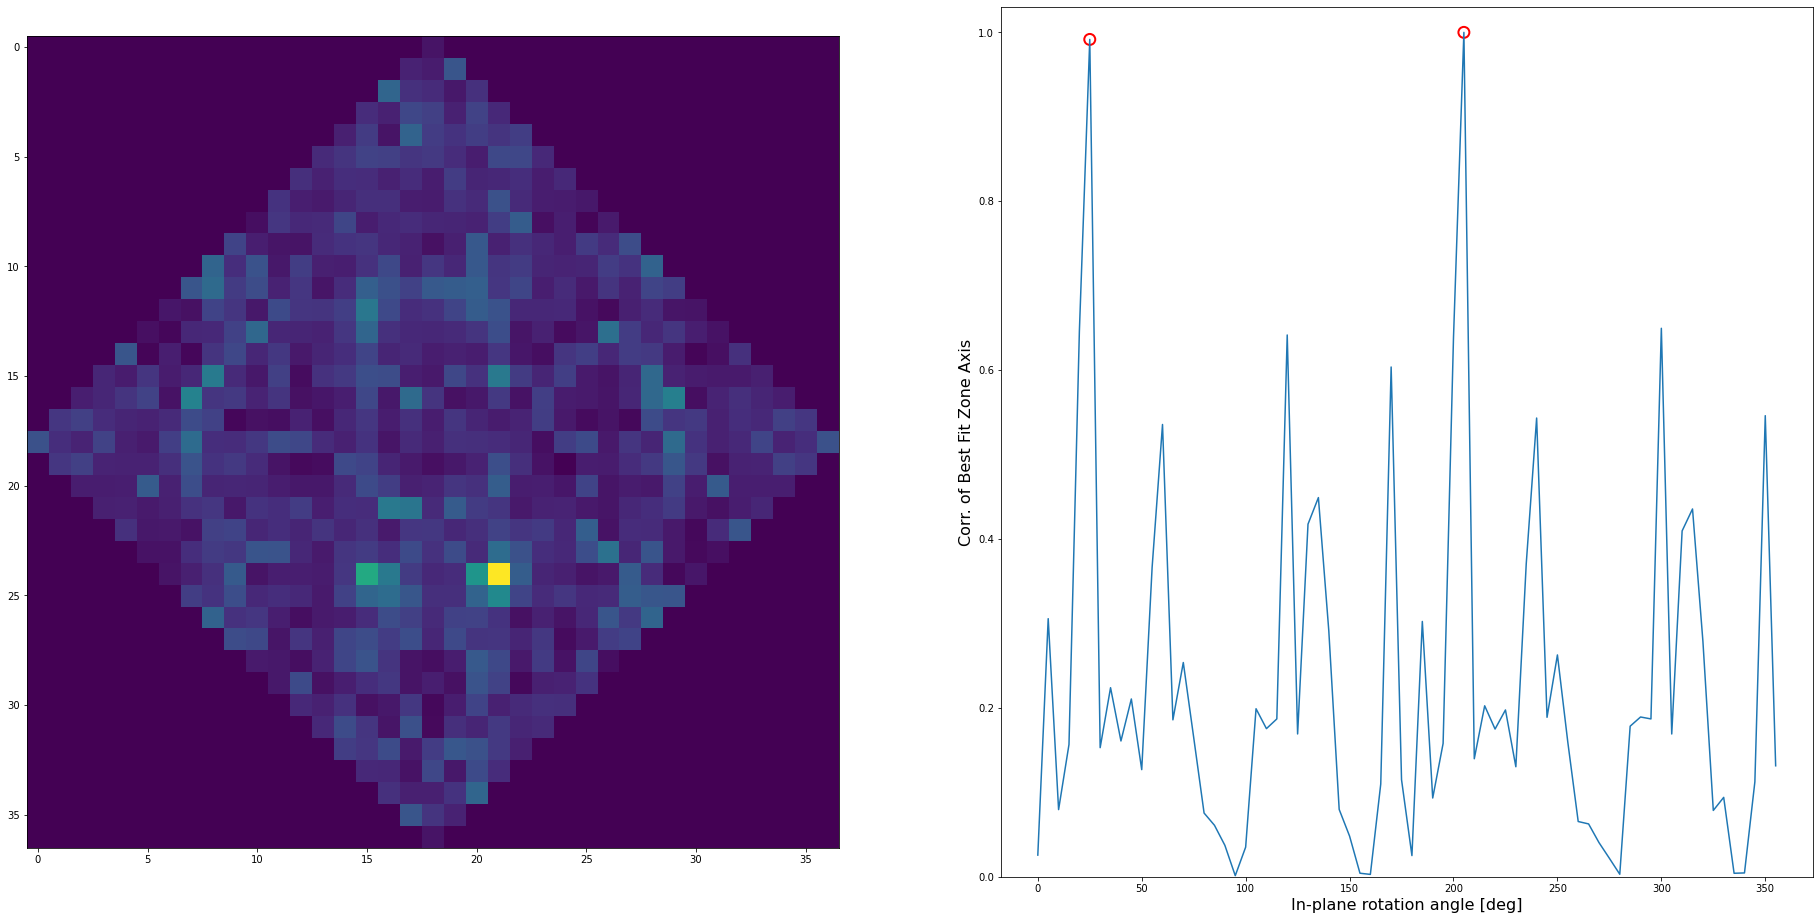

In [406]:
# Testing some matches - this cell shows the orientation correlogram, and the best match for both zone axis and in-plane rotation.
zone_axis_test = np.array([-1,-2,-3])
# zone_axis_test = np.array([1,3,5])

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis = zone_axis_test,
    sigma_excitation_error=0.02)

# Print out zone axes after normalization
t = np.round(zone_axis_test/np.linalg.norm(zone_axis_test)*1e3)/1e3
print('Input zone axis    = (' + str(t) + ')')

# Perform matching, and plot correlation images
orient, fig, ax = crystal.match_single_pattern(
    bragg_peaks,
    figsize=[16,8],
    plot_corr=True,
    verbose=True,
    returnfig=True,
)

In [381]:
# Save the correlation outputs
# fig.savefig('plot_04_match_00.pdf')

In [382]:
# py4DSTEM.process.diffraction.plot_diffraction_pattern?

Input zone axis    = ([0.169 0.507 0.845])
Best fit zone axis = ([0.186 0.516 0.836]) with corr value = 0.471


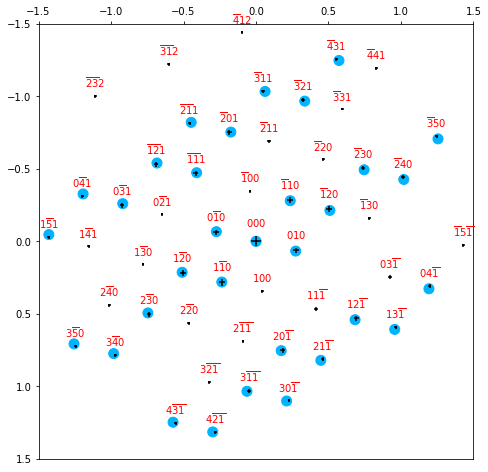

In [383]:
# Testing some matches, plot the best fit orientation over the input
# zone_axis_test = np.array([0,1,1])
# zone_axis_test = np.array([1,2,3])
zone_axis_test = np.array([1,3,5])
x_proj = np.array([0.4,0.5,0.7])  # this is the x projection vector, which sets in-plane rotation

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis = zone_axis_test,
    proj_x_axis=x_proj,
    sigma_excitation_error=0.02)

# Print out zone axes after normalization
t = np.round(zone_axis_test/np.linalg.norm(zone_axis_test), decimals=3)
print('Input zone axis    = (' + str(t) + ')')

# Perform matching
orientation = crystal.match_single_pattern(
    bragg_peaks,
    figsize=[16,8],
    verbose=True,
)

# plot the match overlaid onto the input data
bragg_peaks_fit = crystal.generate_diffraction_pattern(
    orientation,
    sigma_excitation_error=0.03)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks,
    min_marker_size=100,
    plot_range_kx_ky=[k_max,k_max],
    figsize=(8,8)
)


In [384]:
# Save the comparison plots
# fig.savefig('plot_05_comparison.pdf')

### Testing mean error of orientation plan

These further cells are for testing the mean error for a given orientation plan.  It uses the same zone axes as the orientation plan.

In [385]:
def vector_angle(a: np.ndarray, b: np.ndarray) -> float:
    theta = np.arccos(np.clip((a @ b) / (np.linalg.norm(a) * np.linalg.norm(b)), -1.0, 1.0))
    if theta > np.pi/2:
        theta = np.pi - theta
    return theta

In [399]:
test_orientations = crystal.orientation_vecs
test_patterns = py4DSTEM.io.datastructure.PointListArray(bragg_peaks.coordinates,(test_orientations.shape[0],1))

for i in range(test_orientations.shape[0]):
    test_patterns.get_pointlist(i,0).add_dataarray(crystal.generate_diffraction_pattern(
        zone_axis = test_orientations[i,:],
        sigma_excitation_error=0.02,
#         proj_x_axis=[1,0,0],
).data,
)
    
orientation_map = crystal.match_orientations(test_patterns)

Matching Orientations: 100%|██████████████████████████████████████████████████| 685/685 [02:11<00:00,  5.22 PointList/s]


In [403]:
errors = np.zeros((test_orientations.shape[0],))
for i,t in enumerate(test_orientations):
    errors[i] = vector_angle(t,orientation_map.matrix[i,0,0,:,2])

print('Mean angle error = ' + str(np.round(np.mean(errors)*180/np.pi, decimals=3)) + ' degrees')
    
error_img = np.ma.masked_array(np.zeros((crystal.orientation_zone_axis_steps+1, crystal.orientation_zone_axis_steps+1)),mask=True)
diff_intensity_img = np.ma.masked_array(np.zeros((crystal.orientation_zone_axis_steps+1, crystal.orientation_zone_axis_steps+1)),mask=True)
n_spots_img = np.ma.masked_array(np.zeros((crystal.orientation_zone_axis_steps+1, crystal.orientation_zone_axis_steps+1)),mask=True)
for a0 in np.arange(crystal.orientation_zone_axis_steps+1):
    inds = np.arange(a0*(a0+1)/2, a0*(a0+1)/2 + a0 + 1)
    inds_val = np.round(inds).astype('int')
    v = np.arange(a0+1)
    x_inds = a0 - v 
    y_inds = v
    inds1D = np.ravel_multi_index([x_inds,y_inds], error_img.shape)
    
    error_img.ravel()[inds1D] = errors[inds_val]
    error_img.ravel()[inds1D].mask = False
    
    diff_intensity_img[a0,range(a0+1)] = np.array([test_patterns.get_pointlist(i,0).data['intensity'].sum() for i in inds_val])
    diff_intensity_img[a0,range(a0+1)].mask = False
    
    n_spots_img[a0,range(a0+1)] = np.array([test_patterns.get_pointlist(i,0).data['intensity'].shape[0] for i in inds_val])
    n_spots_img[a0,range(a0+1)].mask = False

Mean angle error = 1.977 degrees


In [404]:
import matplotlib.pyplot as plt

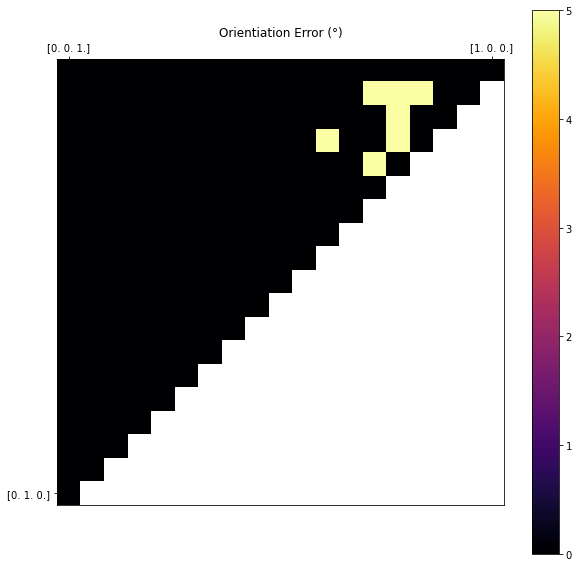

In [405]:
fig,ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap("inferno").copy()
cm.set_bad('w')
im = ax.imshow(np.rad2deg(error_img),cmap=cm,vmin=0,vmax=5)

label_0 = crystal.orientation_zone_axis_range[0,:]
label_0 = np.round(label_0 * 1e3) * 1e-3
label_0 /= np.min(np.abs(label_0[np.abs(label_0)>0]))

label_1 = crystal.orientation_zone_axis_range[1,:]
label_1 = np.round(label_1 * 1e3) * 1e-3
label_1 /= np.min(np.abs(label_1[np.abs(label_1)>0]))

label_2 = crystal.orientation_zone_axis_range[2,:]
label_2 = np.round(label_2 * 1e3) * 1e-3
label_2 /= np.min(np.abs(label_2[np.abs(label_2)>0]))

ax.set_yticks([crystal.orientation_zone_axis_steps])
ax.set_yticklabels([
    str(label_1)])

ax.set_xticks([0, crystal.orientation_zone_axis_steps])
ax.set_xticklabels([
    str(label_0),
    str(label_2)])
ax.xaxis.tick_top()

ax.set_title("Orientiation Error (°)")

fig.colorbar(im)
plt.show()

In [358]:
# Save the correlation outputs
# fig.savefig('plot_11_errors_2deg_kmax_2p0_sigma_0p08.pdf')